In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Clearing Previous Results

In [216]:
import os
#remove results
# Check if the file exists
file_path="/kaggle/working/LSTM-6features-3classesresults.csv"

if os.path.exists(file_path):
    # Remove the file
    os.remove(file_path)
    print(f"{file_path} has been removed.")
else:
    print(f"{file_path} does not exist.")



/kaggle/working/LSTM-6features-3classesresults.csv does not exist.


In [217]:
#remove training logs
import shutil

# Specify the path to the directory
directory_path = '/kaggle/working/Logs'

# Remove the directory and its contents
shutil.rmtree(directory_path)


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/Logs'

# Parameters

In [1]:
epochs=150
batch_size=1024
window_length = 640  # For example, use a window length of 10
num_features=6
number_of_features=6
model_name="LSTM-6features-3classes"
num_classes=2
patience=15
class_names3 = {
    0: 'Normal',
    1: 'Medium',
    2: 'High'
}
class_names2 = {
    0: 'Normal',
    1: 'High'
}

In [2]:
import pandas as pd 
df = pd.read_csv("/kaggle/input/merged_data.csv")
df

/tmp/ipykernel_34/3305823019.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/merged_data.csv")


,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.000000000,2.0
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.031249920,2.0
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.062500096,2.0
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.093750016,2.0
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.124999936,2.0
...,...,...,...,...,...,...,...,...,...
11509046,-16.0,-56.0,24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.875000064,2.0
11509047,-8.0,-50.0,27.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.906249984,2.0
11509048,-28.0,-36.0,28.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.937499904,2.0
11509049,-29.0,-29.0,30.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.968750080,2.0


In [3]:
df['datetime'] = pd.to_datetime(df['datetime'])

# Resample the data into 10-second windows and count the rows in each window
count_per_window = df.resample('10S', on='datetime').count()
print(count_per_window)

/tmp/ipykernel_34/57098114.py:4: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  count_per_window = df.resample('10S', on='datetime').count()


                       X    Y    Z  EDA   HR  TEMP   id  label
datetime                                                      
2020-04-14 22:31:00  320  320  320  320  320   320  320    320
2020-04-14 22:31:10  320  320  320  320  320   320  320    320
2020-04-14 22:31:20  320  320  320  320  320   320  320    320
2020-04-14 22:31:30  320  320  320  320  320   320  320    320
2020-04-14 22:31:40  320  320  320  320  320   320  320    320
...                  ...  ...  ...  ...  ...   ...  ...    ...
2020-12-13 08:00:20  320  320  320  320  320   320  320    320
2020-12-13 08:00:30  320  320  320  320  320   320  320    320
2020-12-13 08:00:40  320  320  320  320  320   320  320    320
2020-12-13 08:00:50  320  320  320  320  320   320  320    320
2020-12-13 08:01:00    1    1    1    1    1     1    1      1

[2094301 rows x 8 columns]


In [4]:
print(set(count_per_window['X']))

{320, 1, 640, 0, 256, 321, 960, 1280, 642, 129, 96, 224, 389, 2, 322, 641, 94}


In [5]:
# Assuming your DataFrame is df and the column is 'ID'
# Convert integer values to strings
df['id'] = df['id'].astype(str)
# Assuming df is your DataFrame
df['label'] = df['label'].replace(1, 0)

# Print the DataFrame to verify the conversion
print(df)


             X     Y     Z       EDA     HR   TEMP  id  \
0        -13.0 -61.0   5.0  6.769995  99.43  31.17  15   
1        -20.0 -69.0  -3.0  6.769995  99.43  31.17  15   
2        -31.0 -78.0 -15.0  6.769995  99.43  31.17  15   
3        -47.0 -65.0 -38.0  6.769995  99.43  31.17  15   
4        -67.0 -57.0 -53.0  6.769995  99.43  31.17  15   
...        ...   ...   ...       ...    ...    ...  ..   
11509046 -16.0 -56.0  24.0  3.386070  88.37  33.77  F5   
11509047  -8.0 -50.0  27.0  3.386070  88.37  33.77  F5   
11509048 -28.0 -36.0  28.0  3.386070  88.37  33.77  F5   
11509049 -29.0 -29.0  30.0  3.386070  88.37  33.77  F5   
11509050 -22.0 -24.0  29.0  3.374543  88.33  33.75  F5   

                              datetime  label  
0        2020-07-08 14:03:00.000000000    2.0  
1        2020-07-08 14:03:00.031249920    2.0  
2        2020-07-08 14:03:00.062500096    2.0  
3        2020-07-08 14:03:00.093750016    2.0  
4        2020-07-08 14:03:00.124999936    2.0  
...            

2


<Figure size 1200x600 with 0 Axes>

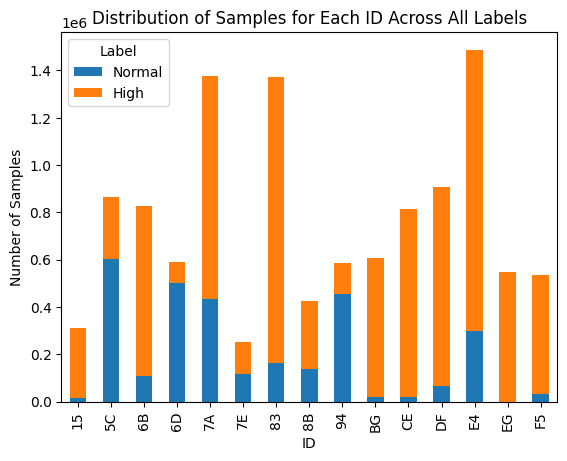

In [6]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Count the number of samples for each ID and label
id_label_counts = df.groupby(['id', 'label']).size().unstack(fill_value=0)

# Plot the grouped bar graph
plt.figure(figsize=(12, 6))
id_label_counts.plot(kind='bar', stacked=True)
plt.xlabel('ID')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples for Each ID Across All Labels')
# 3 classes
count = len(set(df['label']))
print(count)
if count==3:
    plt.legend(title='Label', labels=['Normal','Medium','High'])
# 2 classes
else:
    plt.legend(title='Label', labels=['Normal','High'])
plt.show()

testing_ids = ['7E', '8B','E4']
val_ids=['94','CE']

In [7]:
import matplotlib.pyplot as plt
import pandas as pd


def visualize_class_distribution(df, label_column):
    # Map class labels to categories
    label_mapping = {0: 'Normal', 1: 'Medium', 2: 'High'}
    df['category'] = df[label_column].map(label_mapping)

    # Calculate class counts
    class_counts = df['category'].value_counts()

    # Plotting
    plt.figure(figsize=(8, 8))
    plt.pie(class_counts, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Dataset Class Distribution')
    plt.legend(title='Stress Level', loc='upper right', labels=class_counts.index)
    plt.show()

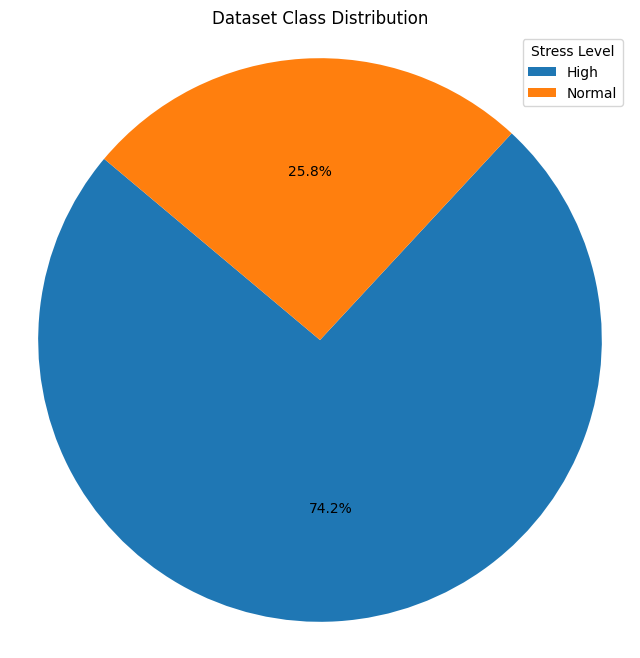

In [8]:
visualize_class_distribution(df, 'label')


In [9]:
df= df.drop(columns=['category'],axis=1)

In [10]:
df.iloc[:, :-1]

,X,Y,Z,EDA,HR,TEMP,id,datetime
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.000000000
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.031249920
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.062500096
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.093750016
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.124999936
...,...,...,...,...,...,...,...,...
11509046,-16.0,-56.0,24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.875000064
11509047,-8.0,-50.0,27.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.906249984
11509048,-28.0,-36.0,28.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.937499904
11509049,-29.0,-29.0,30.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.968750080


In [11]:
#testing data
all_ids = set(df['id'])
exclude_ids = set(testing_ids + val_ids)
train_ids = list(all_ids - exclude_ids)

# Filter the DataFrame based on the specified ID values
Testing_data1 = df[df['id'].isin(testing_ids)]
val_data1 = df[df['id'].isin(val_ids)]
train_data1 = df[df['id'].isin(train_ids)]


del all_ids,val_ids,testing_ids,train_ids

In [12]:
del df

In [13]:
Testing_data1

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
3969315,-44.0,-43.0,-10.0,0.686895,86.50,33.25,7E,2020-10-21 18:46:00.000000000,0.0
3969316,-42.0,-42.0,-8.0,0.686895,86.50,33.25,7E,2020-10-21 18:46:00.031249920,0.0
3969317,-42.0,-42.0,-7.0,0.686895,86.50,33.25,7E,2020-10-21 18:46:00.062500096,0.0
3969318,-46.0,-42.0,-9.0,0.686895,86.50,33.25,7E,2020-10-21 18:46:00.093750016,0.0
3969319,-48.0,-43.0,-8.0,0.686895,86.50,33.25,7E,2020-10-21 18:46:00.124999936,0.0
...,...,...,...,...,...,...,...,...,...
10424216,-40.0,43.0,16.0,1.026040,80.08,31.27,E4,2020-07-06 19:05:59.875000064,2.0
10424217,-38.0,44.0,16.0,1.026040,80.08,31.27,E4,2020-07-06 19:05:59.906249984,2.0
10424218,-38.0,45.0,12.0,1.026040,80.08,31.27,E4,2020-07-06 19:05:59.937499904,2.0
10424219,-41.0,47.0,11.0,1.026040,80.08,31.27,E4,2020-07-06 19:05:59.968750080,2.0


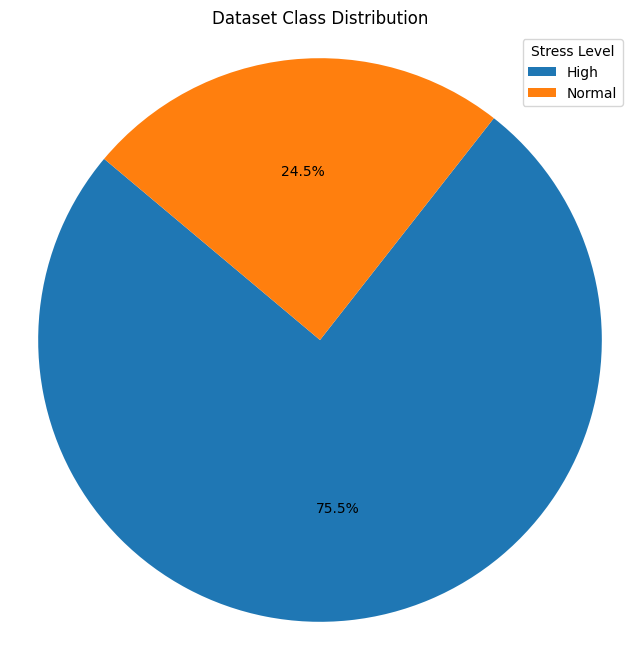

In [14]:
visualize_class_distribution(train_data1, 'label')


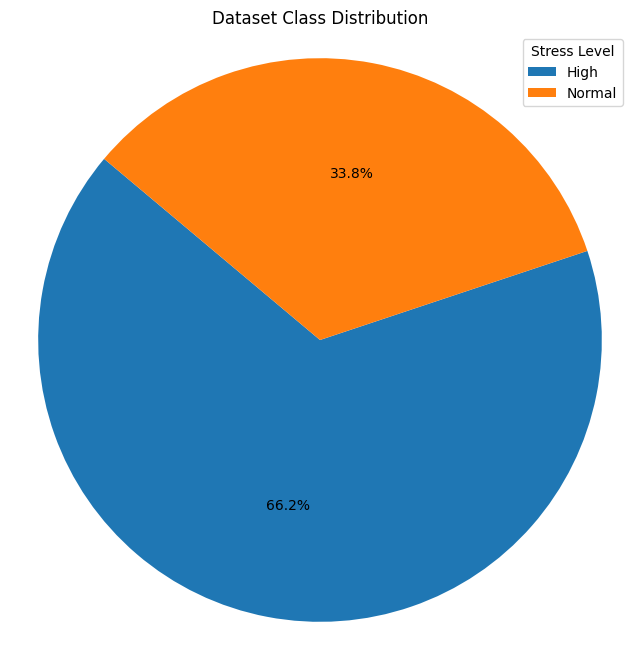

In [15]:
visualize_class_distribution(val_data1, 'label')


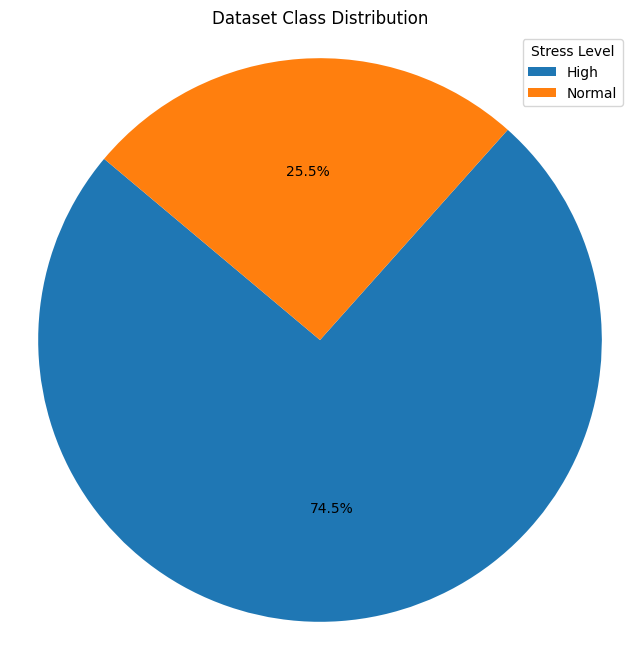

In [16]:
visualize_class_distribution(Testing_data1, 'label')


In [193]:
# train_data1= train_data1.drop(columns=['category'],axis=1)
# test_data1= train_data1.drop(columns=['category'],axis=1)
# val_data1= train_data1.drop(columns=['category'],axis=1)

# test_data1

In [17]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def encode_labels(labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    encoded_labels= to_categorical(encoded_labels)
    return encoded_labels

2024-04-25 18:23:29.307783: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 18:23:29.307888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 18:23:29.443108: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [18]:
# from sklearn.preprocessing import OneHotEncoder
# import numpy as np
# def apply_sliding_windowing(df, window_length, num_features, overlap=0.3,ftrs=['X', 'Y', 'Z']):
#     # Extract features from the DataFrame
#     X = df[ftrs].values

#     # Calculate the number of records after applying sliding windowing
#     stride = int(window_length * (1 - overlap))
#     num_records = (len(X) - window_length) // stride + 1
#     remainder = (len(X) - window_length) % stride

#     # Initialize an empty array to store the reshaped data
#     reshaped_data = np.zeros((num_records, window_length, num_features))

#     # Iterate over the DataFrame to populate the reshaped_data array
#     for i in range(num_records):
#         start = i * stride
#         end = start + window_length
#         reshaped_data[i] = X[start:end]

#     # Pad the last window with zeros along the first axis if the remaining rows are less than the window size
#     if remainder > 0:
#         pad_width = ((0, window_length - remainder), (0, 0))
#         reshaped_data[-1] = np.pad(X[-remainder:], pad_width, mode='constant', constant_values=0)

#     # Extract 'y' from the DataFrame and align it with the shape of X
#     y = df['label'].values[:num_records]
#     y_encoded=encode_labels(y)

#     return reshaped_data, y_encoded

In [19]:
# from sklearn.preprocessing import OneHotEncoder
# import numpy as np
# def apply_sliding_windowing(df, window_length, num_features, overlap=0.3,ftrs=['X', 'Y', 'Z']):
#     # Extract features from the DataFrame
#     X = df[ftrs].values

#     # Calculate the number of records after applying sliding windowing
#     stride = int(window_length * (1 - overlap))
#     num_records = (len(X) - window_length) // stride + 1
#     remainder = (len(X) - window_length) % stride

#     # Initialize an empty array to store the reshaped data
#     reshaped_data = np.zeros((num_records, window_length, num_features))

#     # Iterate over the DataFrame to populate the reshaped_data array
#     for i in range(num_records):
#         start = i * stride
#         end = start + window_length
#         reshaped_data[i] = X[start:end]

#     # Pad the last window with zeros along the first axis if the remaining rows are less than the window size
#     if remainder > 0:
#         pad_width = ((0, window_length - remainder), (0, 0))
#         reshaped_data[-1] = np.pad(X[-remainder:], pad_width, mode='constant', constant_values=0)

#     # Extract 'y' from the DataFrame and align it with the shape of X
#     y = df['label'].values[:num_records]
#     y_encoded=encode_labels(y)

#     return reshaped_data, y_encoded

In [20]:
import numpy as np

def apply_sliding_windowing_new(df, window_length, num_features, overlap=0.3, ftrs=['X', 'Y', 'Z']):
    # Sort the values by 'id' and 'datetime' columns
    df_sorted = df.sort_values(by=['id', 'datetime'])

    # Initialize arrays to store reshaped data and labels
    reshaped_data = []
    labels = []

    # Set the initial start index
    start_idx = 0

    while start_idx + window_length <= len(df_sorted):
        # Set the end index for the current window
        end_idx = start_idx + window_length

        # Create a subset of the DataFrame for the current window
        subset_df = df_sorted.iloc[start_idx:end_idx]

        # Extract features from the subset DataFrame and convert to numpy array
        subset_features = subset_df[ftrs].values
        reshaped_data.append(subset_features)

        # Extract label for the current window and encode it
        label = subset_df['label'].iloc[0]  # Assuming the label is the same for all rows in the window
        labels.append(label)

        # Update the start index for the next window
        start_idx = end_idx - int(window_length * (1 - overlap))

    # Convert the list of arrays to a single numpy array
    reshaped_data = np.array(reshaped_data)

    # Encode labels
    labels_encoded = encode_labels(np.array(labels))

    return reshaped_data, labels_encoded

In [21]:
from sklearn.preprocessing import MinMaxScaler

def apply_minmax_scaling(df,features=['X', 'Y', 'Z']):
    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Apply MinMaxScaler to 'x', 'y', 'z' columns
    df[features] = scaler.fit_transform(df[features])

    return df

# Example usage
# Assuming df is your DataFrame
# df_normalized = apply_minmax_scaling(df)


In [22]:
features = ['X', 'Y', 'Z','EDA','HR','TEMP']
train_data1 = apply_minmax_scaling(train_data1,features=features)
Testing_data1 = apply_minmax_scaling(Testing_data1,features=features)
val_data1 = apply_minmax_scaling(val_data1,features=features)

In [23]:
# print(set(train_data['label']))
# print(set(Testing_data['label']))
# print(set(val_data['label']))

In [24]:
train_data1

,X,Y,Z,EDA,HR,TEMP,id,datetime,label,category
0,0.450980,0.262745,0.521569,0.151849,0.374758,0.5664,15,2020-07-08 14:03:00.000000000,2.0,High
1,0.423529,0.231373,0.490196,0.151849,0.374758,0.5664,15,2020-07-08 14:03:00.031249920,2.0,High
2,0.380392,0.196078,0.443137,0.151849,0.374758,0.5664,15,2020-07-08 14:03:00.062500096,2.0,High
3,0.317647,0.247059,0.352941,0.151849,0.374758,0.5664,15,2020-07-08 14:03:00.093750016,2.0,High
4,0.239216,0.278431,0.294118,0.151849,0.374758,0.5664,15,2020-07-08 14:03:00.124999936,2.0,High
...,...,...,...,...,...,...,...,...,...,...
11509046,0.439216,0.282353,0.596078,0.075948,0.289174,0.7744,F5,2020-07-23 17:28:59.875000064,2.0,High
11509047,0.470588,0.305882,0.607843,0.075948,0.289174,0.7744,F5,2020-07-23 17:28:59.906249984,2.0,High
11509048,0.392157,0.360784,0.611765,0.075948,0.289174,0.7744,F5,2020-07-23 17:28:59.937499904,2.0,High
11509049,0.388235,0.388235,0.619608,0.075948,0.289174,0.7744,F5,2020-07-23 17:28:59.968750080,2.0,High


In [25]:
window_length

640

In [26]:
# window_length=5

In [27]:
print("Processing x_Val1...")
x_val1, y_val1 = apply_sliding_windowing_new(val_data1, window_length, num_features,overlap=0.5,ftrs=features)

print("Processing x_test1...")
x_test1, y_test1 = apply_sliding_windowing_new(Testing_data1, window_length, num_features,overlap=0.5,ftrs=features)

print("Processing x_train1...")
x_train1, y_train1 = apply_sliding_windowing_new(train_data1, window_length, num_features,overlap=0.5,ftrs=features)


# print("Processing x_train2...")
# x_train2, y_train2 = apply_sliding_windowing(train_data2, window_length, num_features,ftrs=['EDA','HR','TEMP'])
# print("Processing x_test2...")
# x_test2, y_test2 = apply_sliding_windowing(Testing_data2, window_length, num_features,ftrs=['EDA','HR','TEMP'])
# print("Processing x_Val2...")
# x_val2, y_val2 = apply_sliding_windowing(val_data2, window_length, num_features,ftrs=['EDA','HR','TEMP'])


# Print the shapes of X and y
# print("data1")
# print(x_train1.shape)  # Check the shape of the reshaped data
# print(x_test1.shape)  # Check the shape of the reshaped data
# print(x_val1.shape)  # Check the shape of the reshaped data
# print(y_train1.shape)  # Check the shape of the reshaped data
# print(y_test1.shape)  # Check the shape of the reshaped data
# print(y_val1.shape)  # Check the shape of the reshaped data
# print("data2")
# print(x_train2.shape)  # Check the shape of the reshaped data
# print(x_test2.shape)  # Check the shape of the reshaped data
# print(x_val2.shape)  # Check the shape of the reshaped data
# print(y_train2.shape)  # Check the shape of the reshaped data
# print(y_test2.shape)  # Check the shape of the reshaped data
# print(y_val2.shape)  # Check the shape of the reshaped data

Processing x_Val1...
Processing x_test1...
Processing x_train1...


In [28]:
print(x_train1.shape)  # Check the shape of the reshaped data
print(x_test1.shape)  # Check the shape of the reshaped data
print(x_val1.shape)  # Check the shape of the reshaped data
print(y_train1.shape)  # Check the shape of the reshaped data
print(y_test1.shape)  # Check the shape of the reshaped data
print(y_val1.shape)  # Check the shape of the reshaped data

(24823, 640, 6)
(6764, 640, 6)
(4374, 640, 6)
(24823, 2)
(6764, 2)
(4374, 2)


In [29]:
import os
import numpy as np

def save_numpy_to_directory(numpy_array, directory, file_name):
    # Create the directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)
    
    # Save the NumPy array to the specified directory
    file_path = os.path.join(directory, file_name)
    np.save(file_path, numpy_array)

In [30]:
directory_path="/kaggle/working"
file_name = "x_train.npy"
save_numpy_to_directory(x_train1, directory_path, file_name)

file_name = "y_train.npy"
save_numpy_to_directory(y_train1, directory_path, file_name)

file_name = "x_test.npy"
save_numpy_to_directory(x_test1, directory_path, file_name)

file_name = "y_test.npy"
save_numpy_to_directory(y_test1, directory_path, file_name)

file_name = "x_val.npy"
save_numpy_to_directory(x_val1, directory_path, file_name)

file_name = "y_val.npy"
save_numpy_to_directory(y_val1, directory_path, file_name)


In [31]:
x_train1.shape

(24823, 640, 6)

In [32]:
import numpy as np

def load_numpy_from_file(file_path):
    # Load the NumPy array from the specified file path
    numpy_array = np.load(file_path)
    return numpy_array



In [33]:
# Example usage
file_path = "/kaggle/working/x_train.npy"
x_train = load_numpy_from_file(file_path)
# Example usage
file_path = "/kaggle/working/y_train.npy"
y_train = load_numpy_from_file(file_path)
# Example usage
file_path = "/kaggle/working/x_test.npy"
x_test = load_numpy_from_file(file_path)
# Example usage
file_path = "/kaggle/working/y_test.npy"
y_test = load_numpy_from_file(file_path)
# Example usage
file_path = "/kaggle/working/x_val.npy"
x_val = load_numpy_from_file(file_path)
# Example usage
file_path = "/kaggle/working/y_val.npy"
y_val = load_numpy_from_file(file_path)


In [34]:
print(x_train1.shape)  # Check the shape of the reshaped data
print(x_test1.shape)  # Check the shape of the reshaped data
print(x_val1.shape)  # Check the shape of the reshaped data
print(y_train1.shape)  # Check the shape of the reshaped data
print(y_test1.shape)  # Check the shape of the reshaped data
print(y_val1.shape)  # Check the shape of the reshaped data

(24823, 640, 6)
(6764, 640, 6)
(4374, 640, 6)
(24823, 2)
(6764, 2)
(4374, 2)


In [35]:
print(x_train.shape)  # Check the shape of the reshaped data
print(x_test.shape)  # Check the shape of the reshaped data
print(x_val.shape)  # Check the shape of the reshaped data
print(y_train.shape)  # Check the shape of the reshaped data
print(y_test.shape)  # Check the shape of the reshaped data
print(y_val.shape)  # Check the shape of the reshaped data

(24823, 640, 6)
(6764, 640, 6)
(4374, 640, 6)
(24823, 2)
(6764, 2)
(4374, 2)


In [36]:
#11509051 rows

In [37]:
# del train_data1,Testing_data1,val_data1,train_data2,Testing_data2,val_data2

In [38]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, Input, concatenate
from tensorflow.keras.utils import plot_model
from keras.metrics import Recall

def create_single_lstm_model(num_classes, window_length, number_of_features, lstm_units1=265, lstm_units2=128,dense_layers=3,dense_units=256,nn_dropout=0.2):
    # Initialize the model
    input_all = Input(shape=(window_length, number_of_features), name='input_data')

    branch1 = LSTM(lstm_units1,dropout=0.2, recurrent_dropout=0.2, return_sequences=True, name='lstm_layer_1')(input_all)
    branch1 = LSTM(lstm_units2,dropout=0.2, recurrent_dropout=0.2 ,name='lstm_layer_2')(branch1)
    branch1 = Flatten(name='flatten_sensor')(branch1)


    # Add a dense layer for the output
    for _ in range(dense_layers):
        branch1 = Dense(dense_units, activation="relu")(branch1)
        branch1 = Dropout(nn_dropout)(branch1)
        dense_units= int(dense_units/2)

    output_layer = Dense(num_classes, activation='softmax', name='output')(branch1)

    model = tf.keras.Model(inputs=input_all, outputs=output_layer, name='single_lstm_model')

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[Recall()])

    return model

Model: "single_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_data (InputLayer)         │ (None, 640, 6)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_1 (LSTM)             │ (None, 640, 265)       │       288,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_2 (LSTM)             │ (None, 128)            │       201,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_sensor (Flatten)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 556,226 (2.12 MB)

 Trainable params: 556,226 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

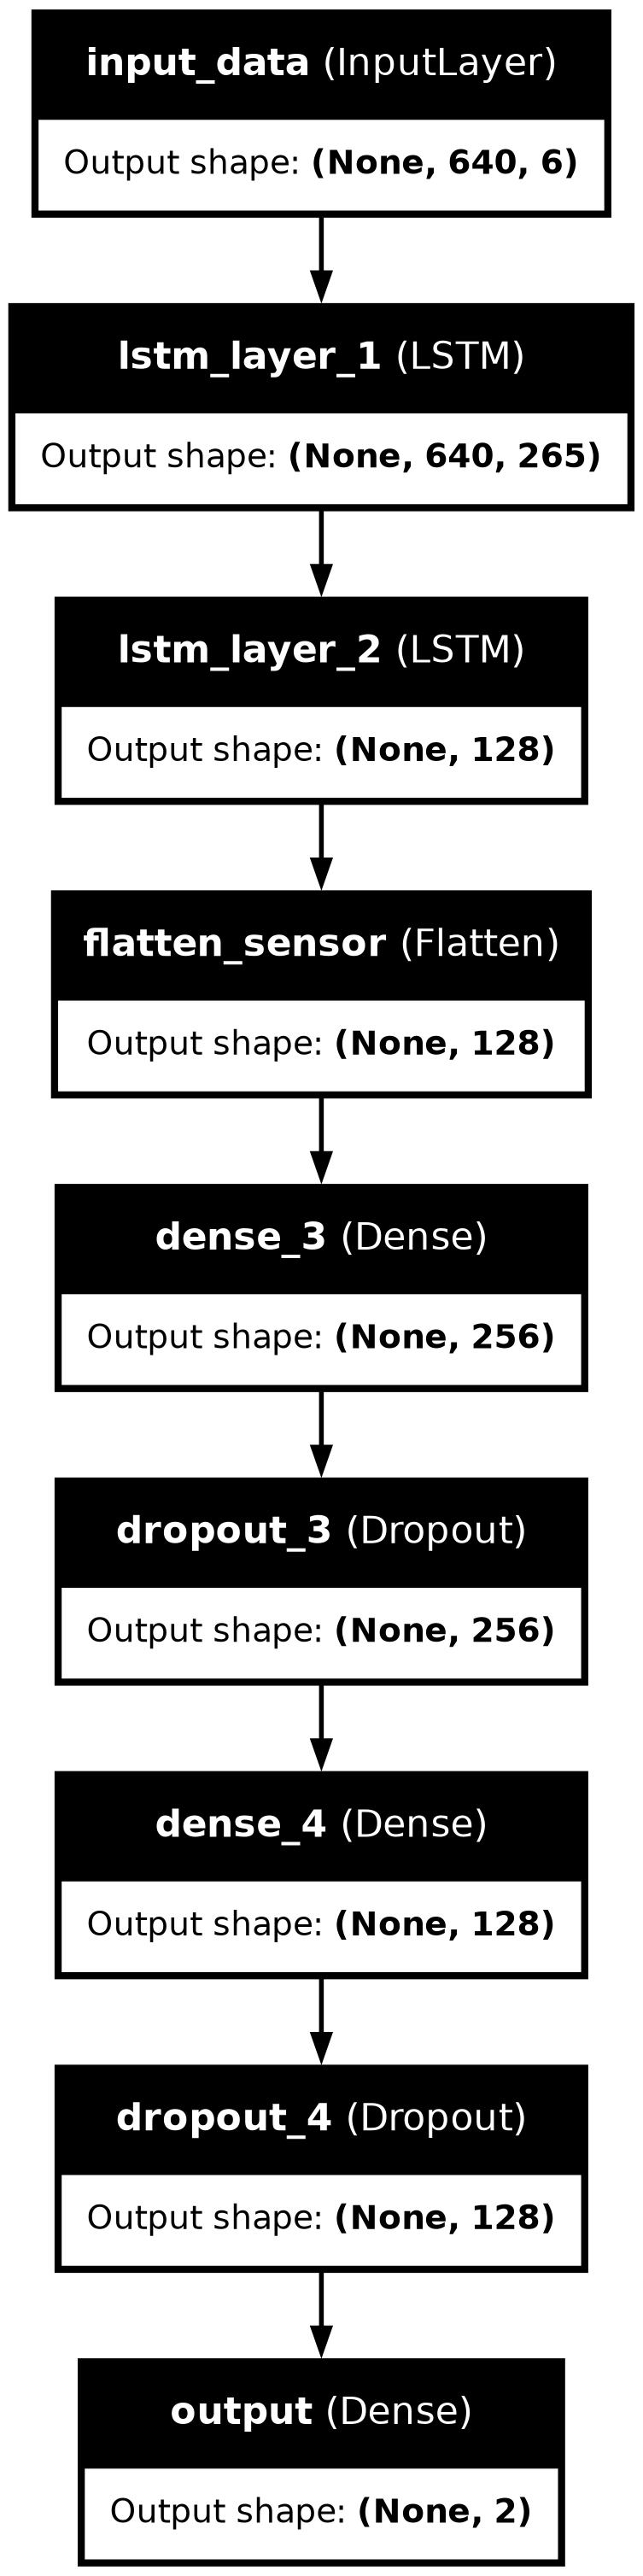

In [40]:
model = create_single_lstm_model(num_classes,window_length, number_of_features,dense_layers=2)

# Print the model summary
model.summary()
plot_model(model, to_file=model_name+"_arc.png", show_shapes=True,show_layer_names=True)


In [41]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, CSVLogger
import os
def addCallbacks(model_name):
    cllbks = []
    # Define the callback
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',  # You can use 'val_accuracy' or other metrics
        factor=0.1,           # Factor by which the learning rate will be reduced. new_lr = lr * factor
        patience=5,           # Number of epochs with no improvement after which learning rate will be reduced
        min_lr=1e-6,          # Lower bound on the learning rate
        verbose=1
    )
    cllbks.append(reduce_lr)
    # Define the EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=patience,   # Number of epochs with no improvement before stopping
        verbose=1,           # Verbosity level (1 for updates, 0 for silent)
        restore_best_weights=True  # Restore model weights to the best observed during training
    )
    cllbks.append(early_stopping)
    log_dir = "Logs/" + model_name
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    csv_logger_callback = CSVLogger(log_dir + '/logs.csv')
    cllbks.append(csv_logger_callback)
    # log_dir = save_folder + "Logs/" + model_name
    # tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    # # cllbks.append(tensorboard_callback)
    return cllbks
# callbacks=addCallbacks()

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report

def testModel(mdl, X_test1, y_test):
    # Predictions from the model
    y_pred = mdl.predict(X_test1)

    # Convert predictions to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
    recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
    f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
#     auc = roc_auc_score(y_test, y_pred, multi_class='ovr')

    report = classification_report(y_test_labels, y_pred_labels)
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print(report)
#     print("AUC:", auc)
    print("Confusion Matrix:\n", conf_matrix)

    return conf_matrix, accuracy, precision, recall, f1

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(confusion_matrix, class_names=None, save_path=None):
    """
    Plot a confusion matrix as a heatmap.

    Parameters:
    - confusion_matrix (numpy.ndarray): Confusion matrix.
    - class_names (dict): Dictionary mapping class numbers to class names.
    - save_path (str): Path to save the heatmap plot. If None, the plot is displayed but not saved.

    Returns:
    - None
    """
    plt.figure(figsize=(8, 6))

    # Using Seaborn heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[class_names[i] for i in range(confusion_matrix.shape[0])] if class_names else None,
                yticklabels=[class_names[i] for i in range(confusion_matrix.shape[1])] if class_names else None)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()

# Example usage:
# Assuming you have a confusion matrix named 'conf_matrix'
# and a class_names dictionary mapping class numbers to class names
# and you want to save the heatmap to a file named 'confusion_matrix_heatmap.png'
# plot_confusion_matrix(conf_matrix, class_names=class_names, save_path='confusion_matrix_heatmap_extracted.png')


In [44]:
import pandas as pd

def append_to_csv(file_path, model_name, accuracy, precision, recall, f1_score):
    """
    Append a row with evaluation metrics to an existing CSV file.

    Parameters:
    - file_path: The path to the CSV file.
    - model_name: Name of the model.
    - accuracy: Accuracy value.
    - precision: Precision value.
    - recall: Recall value.
    - f1_score: F1 score value.
    - testing_time: Time taken for testing in seconds.
    - training_time: Time taken for training in seconds.
    """

    headers = ['Model Name', 'Accuracy', 'Precision', 'Recall', 'F1-Score']

    # Check if the file exists
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        # If the file doesn't exist, create a new one with headers
        df = pd.DataFrame(columns=headers)

    # Append a new row with the specified values
    new_row = pd.DataFrame([[model_name, accuracy, precision, recall, f1_score]], columns=headers)
    df = pd.concat([df, new_row], ignore_index=True)

    # Save to the same CSV file
    df.to_csv(file_path, index=False)

    print(f"Row appended to '{file_path}' successfully.")

# Example usage:
# csv_file_path = "evaluation_metrics.csv"
# append_to_csv(csv_file_path, "ExampleModel", 0.85, 0.88, 0.82, 0.85, 30, 120)


In [45]:
print("data1")
print(x_train.shape)  # Check the shape of the reshaped data
print(x_val.shape)  # Check the shape of the reshaped data
print(y_train.shape)  # Check the shape of the reshaped data
print(y_val.shape)  # Check the shape of the reshaped data

data1
(24823, 640, 6)
(4374, 640, 6)
(24823, 2)
(4374, 2)


In [46]:
import time
callb=addCallbacks(model_name)
start_time = time.time()
history = model.fit(x_train,y_train, epochs=epochs, validation_data=(x_val,y_val),batch_size = batch_size,callbacks=callb)
end_time = time.time()
durationt = end_time - start_time
print(durationt)

Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - loss: 0.5934 - recall_1: 0.6918 - val_loss: 0.6917 - val_recall_1: 0.6621 - learning_rate: 0.0010
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.5329 - recall_1: 0.7565 - val_loss: 0.6906 - val_recall_1: 0.6621 - learning_rate: 0.0010
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.5242 - recall_1: 0.7529 - val_loss: 0.6581 - val_recall_1: 0.6621 - learning_rate: 0.0010
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.5144 - recall_1: 0.7567 - val_loss: 0.6473 - val_recall_1: 0.6621 - learning_rate: 0.0010
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 0.5157 - recall_1: 0.7569 - val_loss: 0.7341 - val_recall_1: 0.6735 - learning_rate: 0.0010
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.5118 - recall_1: 0.7630 - val_loss: 0.6904 - val_recall_1: 0.6719 - learning_rate: 0.0010
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.5144 - recall_1: 0.7652 - val_los

In [47]:
cf,accuracy,precision,recall,f1= testModel(model, x_test, y_test)

212/212 ━━━━━━━━━━━━━━━━━━━━ 88s 415ms/step
Accuracy: 0.7474866942637493
Precision: 0.7273328545203386
Recall: 0.7474866942637493
F1 Score: 0.646465750458191
              precision    recall  f1-score   support

           0       0.67      0.02      0.04      1725
           1       0.75      1.00      0.85      5039

    accuracy                           0.75      6764
   macro avg       0.71      0.51      0.45      6764
weighted avg       0.73      0.75      0.65      6764

Confusion Matrix:
 [[  34 1691]
 [  17 5022]]


Row appended to 'LSTM-6features-3classesresults.csv' successfully.


/tmp/ipykernel_34/3030835386.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


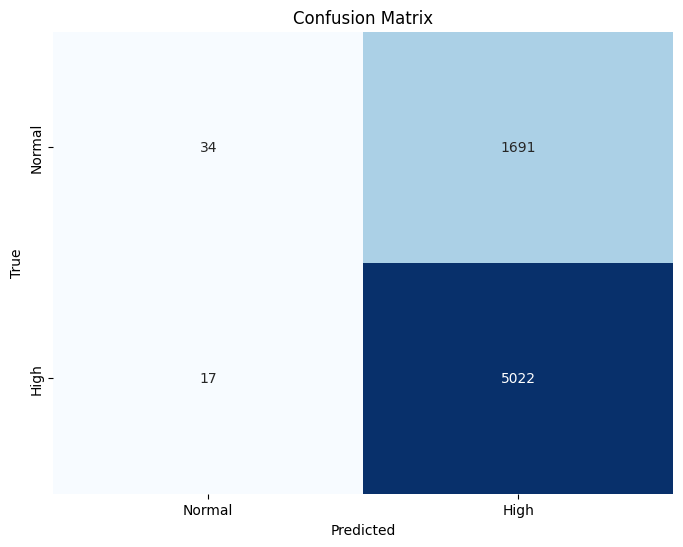

In [48]:
plot_confusion_matrix(cf, save_path='confusion_matrix_'+model_name+'.png',class_names=class_names2)
append_to_csv(model_name+"results.csv", model_name, accuracy,precision,recall,f1)

In [ ]:
print("sdasd")

In [ ]:
# # Evaluate the model on the validation data
# loss, accuracy = model.evaluate([x_test1,x_test2], y_test1)
# print(f'Validation loss: {loss}, Validation accuracy: {accuracy}')

In [ ]:
import os

# Kill the current process (this will disconnect the runtime)
os.kill(os.getpid(), 9)


In [49]:
import zipfile
import os

def zip_directory(directory_path, zip_path):
    # Create a ZipFile object
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Iterate over all the files in the directory
        for root, _, files in os.walk(directory_path):
            for file in files:
                # Add each file to the zip file
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, directory_path))

# Example usage
directory_path = "/kaggle/working/Logs"
zip_path = "/kaggle/working/logs.zip"
zip_directory(directory_path, zip_path)
